# Hypergrams
[Plotly express](https://plotly.com/python/plotly-express/) makes it pretty straightforward to create HTML [hypergrams](https://worrydream.com/refs/Nelson_T_1974_-_Computer_Lib,_Dream_Machines.pdf). These can then be shared by email and opened locally in a browser, or embedded in a webpage. These aren't really relevant to OpenSpace (unless you want to open them in an embedded browser window) but they might come in handy if you want a lightweight interactive visualization.

In [3]:
import plotly.express as px

from datetime import datetime as dt
import pandas as pd
import openspace_rvdata.r2r2df as r2r
import openspace_rvdata.geocsv2geojson as g2g

import logging
logger = logging.getLogger(__name__)

## Ship Track Visualization 
Are you reading [this book](https://milkweed.org/book/the-quickening) and trying to sort out what's happening when? That was [NBP1902](https://www.rvdata.us/search/cruise/NBP1902). 

In [ ]:
# BEST VERSION SO FAR

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import io

# Read the CSV data directly from the file.
# The 'comment='#' will automatically skip lines starting with '#'.
# df = pd.read_csv("RR2402_1min.geoCSV", comment='#')
# df = df.head(10000)
df = pd.read_csv("tmp/NBP1902_control.geoCSV", comment='#')

# Convert 'iso_time' column to datetime objects
df['iso_time'] = pd.to_datetime(df['iso_time'])

# Sort the DataFrame by time to ensure correct animation order
df = df.sort_values(by='iso_time')

# Add a 'trace_id' column for the animation_group.
# By making this a constant, Plotly Express will draw the entire trace
# up to the current animation frame, creating a persistent trail.
df['trace_id'] = 'ship_track'

# Create the animated geoscatter plot using plotly express
# 'lon' for longitude, 'lat' for latitude
# 'animation_frame' is set to 'iso_time' to create the animation
# 'animation_group' is set to 'trace_id' to make the line persist
# 'title' provides a descriptive title for the plot
# 'height' sets the height of the plot
# 'size_max' adjusts the marker size for the current point
# 'projection' sets the map projection type
fig = px.scatter_geo(df,
                     lon="ship_longitude",
                     lat="ship_latitude",
                    #  color="speed_made_good",
                     animation_frame="iso_time",
                     animation_group="trace_id", # This makes the line persist
                     title="RR2402 Ship Track",
                     height=600,
                     size_max=500,
                     projection="natural earth", # Or "orthographic", "mercator", "winkel3", etc.
                     labels={"ship_longitude": "Longitude", "ship_latitude": "Latitude", "iso_time": "Time"}
                    )
# Create line trace
line_trace = go.Scattergeo(lat=df['ship_latitude'], lon=df['ship_longitude'], mode='lines', name='line')
# Add line trace to the figure
fig.add_trace(line_trace)
fig.update_traces(line=dict(width=2)) # Set the line width to 2 (adjust as needed)


# ---
## Centering the Map
# ---

# Update the geographic scope to center the map over Southern California
fig.update_geos(
    center=dict(lat=33.5, lon=-118),  # Approximate center of Southern California
    lataxis_range=[30, 37],  # Latitude range for Southern California
    lonaxis_range=[-124, -114], # Longitude range for Southern California
    landcolor="rgb(243, 243, 243)",
    countrycolor="rgb(204, 204, 204)"
)

# ---
## Adjusting Animation Speed
# ---

# Update layout for better aesthetics, including adjusting the animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500  # Adjust animation speed in milliseconds
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 200 # Adjust transition duration

# Show the plot
fig.update_layout(showlegend=False)
fig.show()
fig.write_html('RR2402.html')

## Gantt Chart: Multiple Cruises in Context

In [13]:
min(mdf['latitude_min'])
# todo: restrict to only polar cruises (use min and max lat)
mdf["is_arctic"]= mdf['latitude_max'] > 60
mdf["is_antarctic"]= mdf['latitude_min'] < -60

In [4]:
# mdf[mdf.has_r2rnav == False].is_retrieved
import plotly.express as px
title = "Cruises"

# url = r2r.get_r2r_url(vessel_name = "Palmer")
url = "https://service.rvdata.us/api/cruise/"
mdf = r2r.get_cruise_metadata(url)
mdf['waterbody_name'] = mdf['waterbody_name'].fillna("Not listed")
# mdf['waterbody_name'] = mdf['waterbody_name'].replace("null", "Not listed")  # Replace all 2s with 10 in column 'A'

mdf.head()

,cruise_id,cruise_name,cruise_type,cruise_url,cruise_doi,is_registered,vessel_ices_code,vessel_id,vessel_name,vessel_shortname,...,is_ingmrt,is_blanket_release,vessel_acronym,longitude_min,longitude_max,latitude_min,latitude_max,cruise_reports,redirect_to_mgds,keyword_list
0,HX293,GLOBEC Long Term Observation Program (LTOP),op_science,http://www.globec.org/,10.7284/901644,True,31HX,Alpha Helix,Alpha Helix,Helix,...,False,None,HX,-150.26233,-146.55000,58.07983,60.73700,None,False,[globec long term observation program (ltop)al...
1,HX292,GLOBEC Long Term Observation Program (LTOP),op_science,http://www.globec.org/,10.7284/901643,True,31HX,Alpha Helix,Alpha Helix,Helix,...,False,None,HX,-149.47433,-146.48517,58.08217,60.59033,None,False,[globec long term observation program (ltop)al...
2,HX291,Mooring Recovery,op_service,None,10.7284/901642,True,31HX,Alpha Helix,Alpha Helix,Helix,...,False,None,HX,-175.88747,-167.69115,56.14883,63.25852,None,False,[mooring recoveryalpha helixalpha helixhelixed...
3,HX290,Shelf-Basin Interactions (SBI) - Moorings,op_science,http://www.eol.ucar.edu/projects/sbi/,10.7284/901641,True,31HX,Alpha Helix,Alpha Helix,Helix,...,False,None,HX,-169.03737,-165.60752,64.48492,69.17555,https://service.rvdata.us/data/cruise/HX290/do...,False,[shelf-basin interactions (sbi) - mooringsalph...
4,HX289,Gravel Resource Potential in the Southeast Chu...,op_science,None,10.7284/901640,True,31HX,Alpha Helix,Alpha Helix,Helix,...,False,None,HX,-168.31858,-164.08015,65.35507,68.34283,None,False,[gravel resource potential in the southeast ch...


In [73]:
# mdf['wrapped_text'] = mdf['cruise_name'].str.wrap(30).apply(lambda x: x.replace('\n', '<br>'))
mdf['wrapped_text'] = mdf['cruise_name'].fillna('').str.wrap(30).apply(lambda x: x.replace('\n', '<br>'))


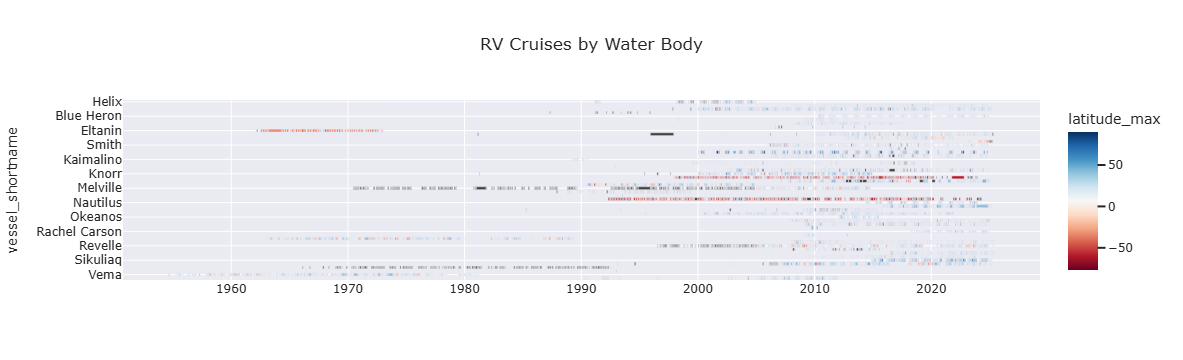

In [74]:
title = "RV Cruises by Water Body"

# TODO: add absolute lat column latitude_abs = max(abs(latitude_max), abs(latitude_min))

# Wrap the text and replace newlines with <br>
mdf['wrapped_text'] = mdf['cruise_name'].fillna('').str.wrap(30).apply(lambda x: x.replace('\n', '<br>'))


fig = px.timeline(
    mdf,
    x_start="depart_date",
    x_end="arrive_date",
    y="vessel_shortname",  # This will be the label for each bar on the y-axis
    color="latitude_max", # You can color by the same ID or another categorical column
    color_continuous_scale=px.colors.sequential.RdBu, # use RdBu divergent colormap to highlight polar cruises
    title=title,
    # Other optional arguments:
    hover_name="wrapped_text", # Show more info on hover
    hover_data=["cruise_id", "waterbody_name", "cruise_doi"], # Show more info on hover
    # text="label_on_bar", # Text directly on the bar
    # facet_row="some_category", # For breaking down by a category
    # template="plotly_white" # or "plotly_dark", "ggplot2", "seaborn", etc.
    template = "seaborn"
)

# You might want to sort the y-axis (tasks) for better readability
fig.update_yaxes(autorange="reversed") # To display the first task at the top

fig.show()
fig.write_html("plots/RV Cruises by Waterbody.html")

Now let's look just at polar cruises. 

TODO: R2R doesn't have position information listed for all of these. See if there's a way to extract it from the data and populate that part of the dataframe, or ask them to fix it. 

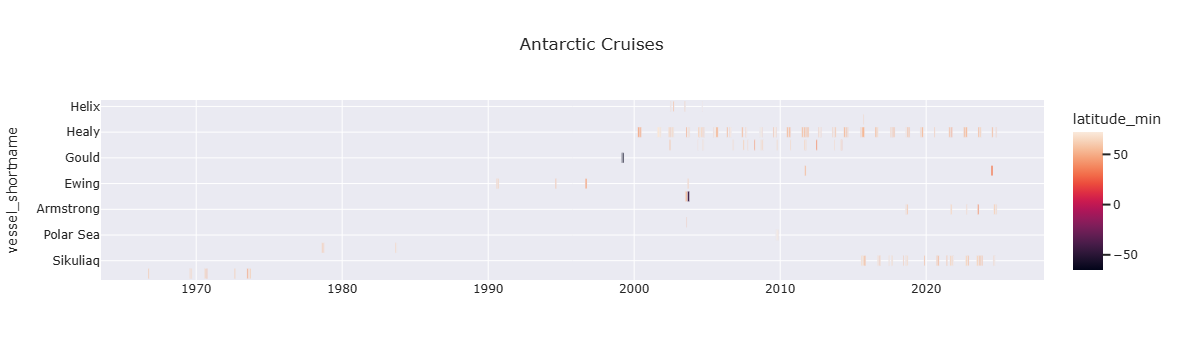

In [27]:


# restrict to only polar cruises (use min and max lat)
mdf["is_arctic"]= mdf['latitude_max'] > 65
mdf["is_antarctic"]= mdf['latitude_min'] < -60

mdf_arctic = mdf[mdf.is_arctic == True]
mdf_antarctic = mdf[mdf.is_arctic == True]


title = "Antarctic Cruises"
fig = px.timeline(
    mdf_antarctic,
    x_start="depart_date",
    x_end="arrive_date",
    y="vessel_shortname",  # This will be the label for each bar on the y-axis
    color="latitude_min", # You can color by the same ID or another categorical column
    title=title,
    # Other optional arguments:
    hover_name="cruise_name", # Show more info on hover
    hover_data=["cruise_id", "waterbody_name", "cruise_doi"], # Show more info on hover
    # text="label_on_bar", # Text directly on the bar
    # facet_row="some_category", # For breaking down by a category
    # template="plotly_white" # or "plotly_dark", "ggplot2", "seaborn", etc.
    template = "seaborn"
)

# You might want to sort the y-axis (tasks) for better readability
fig.update_yaxes(autorange="reversed") # To display the first task at the top

fig.show()
fig.write_html("plots/Antarctic Cruises.html")

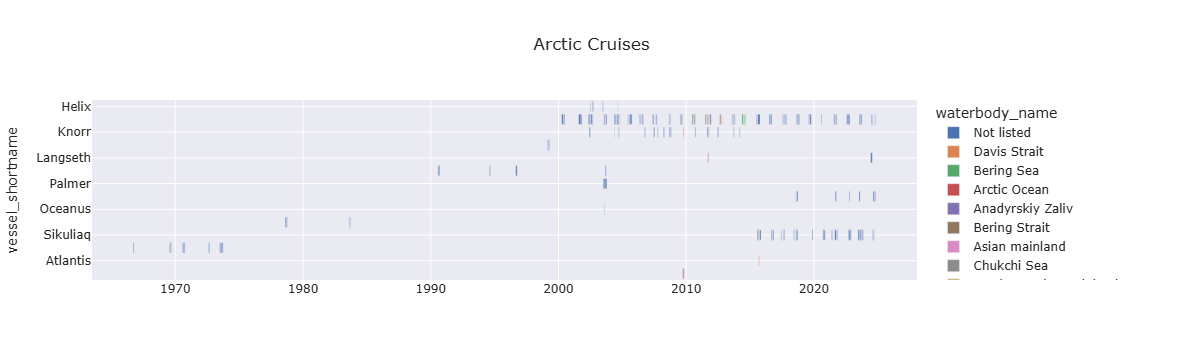

In [20]:
title = "Arctic Cruises"
fig = px.timeline(
    mdf_arctic,
    x_start="depart_date",
    x_end="arrive_date",
    y="vessel_shortname",  # This will be the label for each bar on the y-axis
    color="waterbody_name", # You can color by the same ID or another categorical column
    title=title,
    # Other optional arguments:
    hover_name="cruise_name", # Show more info on hover
    hover_data=["cruise_id", "waterbody_name", "cruise_doi"], # Show more info on hover
    # text="label_on_bar", # Text directly on the bar
    # facet_row="some_category", # For breaking down by a category
    # template="plotly_white" # or "plotly_dark", "ggplot2", "seaborn", etc.
    template = "seaborn"
)

# You might want to sort the y-axis (tasks) for better readability
fig.update_yaxes(autorange="reversed") # To display the first task at the top

fig.show()
fig.write_html("plots/Arctic Cruises.html")

### Gantt chart, filtered by keyword
Suppose we want to check all the cruises that relate to a given topic. Here's some example code for that.

In [44]:
# # Initialize an empty set to store unique keywords
# unique_keywords = set()

# # Iterate through each list in the 'keyword_list' column
# for keywords_list in mdf['keyword_list']:
#     # Add all keywords from the current list to the set
#     unique_keywords.update(keywords_list)

# # Convert the set to a list (optional, if you specifically need a list)
# list_of_unique_keywords = sorted(list(unique_keywords)) # Sorted for readability

# # list_of_unique_keywords

In [76]:
# The keyword you want to filter by
keyword_to_find = "Iron"

# Filter the DataFrame
# filtered_mdf = mdf[mdf['keyword_list'].apply(lambda x: keyword_to_find in x)]
filtered_cruises = mdf[mdf['cruise_name'].str.contains(keyword_to_find, case=True, na=False)]
# filtered_cruises

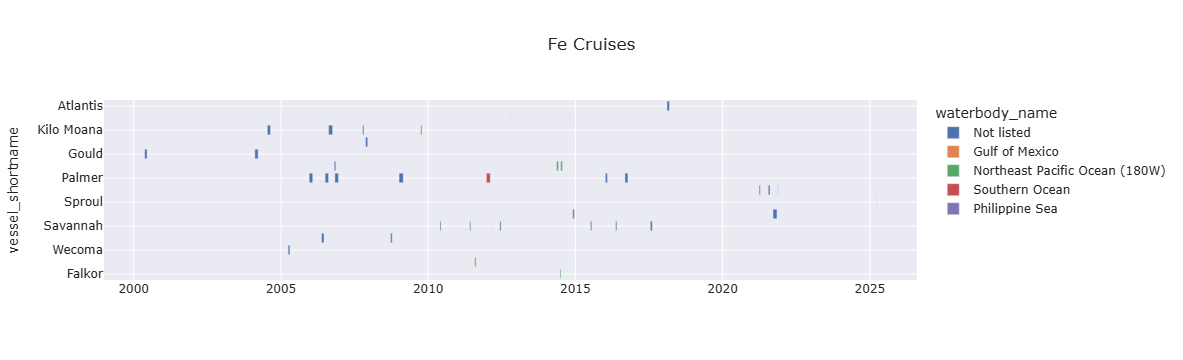

In [77]:
title = "Fe Cruises"
fig = px.timeline(
    filtered_cruises,
    x_start="depart_date",
    x_end="arrive_date",
    y="vessel_shortname",  # This will be the label for each bar on the y-axis
    color="waterbody_name", # You can color by the same ID or another categorical column
    title=title,
    # Other optional arguments:
    hover_name="wrapped_text", # Show more info on hover
    hover_data=["cruise_id", "waterbody_name", "cruise_doi"], # Show more info on hover
    # text="label_on_bar", # Text directly on the bar
    # facet_row="some_category", # For breaking down by a category
    # template="plotly_white" # or "plotly_dark", "ggplot2", "seaborn", etc.
    template = "seaborn"
)

# You might want to sort the y-axis (tasks) for better readability
fig.update_yaxes(autorange="reversed") # To display the first task at the top

fig.show()
fig.write_html("plots/Fe Cruises.html")